In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from pathlib import Path
import textwrap

In [4]:
# # Read the data
# # Function to clean quarter label from filename
# def get_quarter_label(filename):
#     match = re.search(r'Q(\d)', filename)
#     if match:
#         return f'Q{match.group(1)}'
#     return filename

# # Read all Excel files from 'polls' directory
# polls_dir = Path('polls')
# files = sorted([f for f in polls_dir.glob('*.xlsx')])

# # Read all dataframes
# dfs = {get_quarter_label(file.name): pd.read_excel(file) for file in files}
# Function to clean quarter name from filename
# def get_quarter_label(filename):
#     match = re.search(r'Q(\d)', filename)
#     if match:
#         return f'Q{match.group(1)}'
#     return filename
def get_quarter_label(filename):
    # Look for patterns like '2024-Q3' or '2024 Q3'
    match = re.search(r'(\d{4})[- ]Q(\d)', filename)
    if match:
        year, quarter = match.groups()
        return f"{year}-Q{quarter}"
    return filename

# Function to safely read Excel file
def safe_read_excel(file_path):
    try:
        # First try with openpyxl engine (for .xlsx files)
        return pd.read_excel(file_path, engine='openpyxl')
    except Exception as e1:
        try:
            # If that fails, try with xlrd engine (for .xls files)
            return pd.read_excel(file_path, engine='xlrd')
        except Exception as e2:
            print(f"Error reading file {file_path}: {str(e2)}")
            return None

# Read all files from the polls directory
polls_dir = Path('polls')
if not polls_dir.exists():
    raise ValueError(f"Directory 'polls' not found in {polls_dir.absolute()}")

# Get all Excel files and sort them
files = sorted([f for f in polls_dir.glob('*.xlsx')])
#files = sorted([f for f in polls_dir.glob('*.xlsx')], reverse=True)

if not files:
    raise ValueError("No Excel files found in the 'polls' directory")

# Read all dataframes with error handling
dfs = {}
for file in files:
    print(f"Reading file: {file.name}")  # Debug print
    df = safe_read_excel(file)
    if df is not None:
        dfs[get_quarter_label(file.name)] = df

if not dfs:
    raise ValueError("No valid Excel files could be read")

print(f"Successfully loaded {len(dfs)} files: {list(dfs.keys())}")  # Debug print

Reading file: 2024-Q2.xlsx
Reading file: 2024-Q3.xlsx
Successfully loaded 2 files: ['2024-Q2', '2024-Q3']


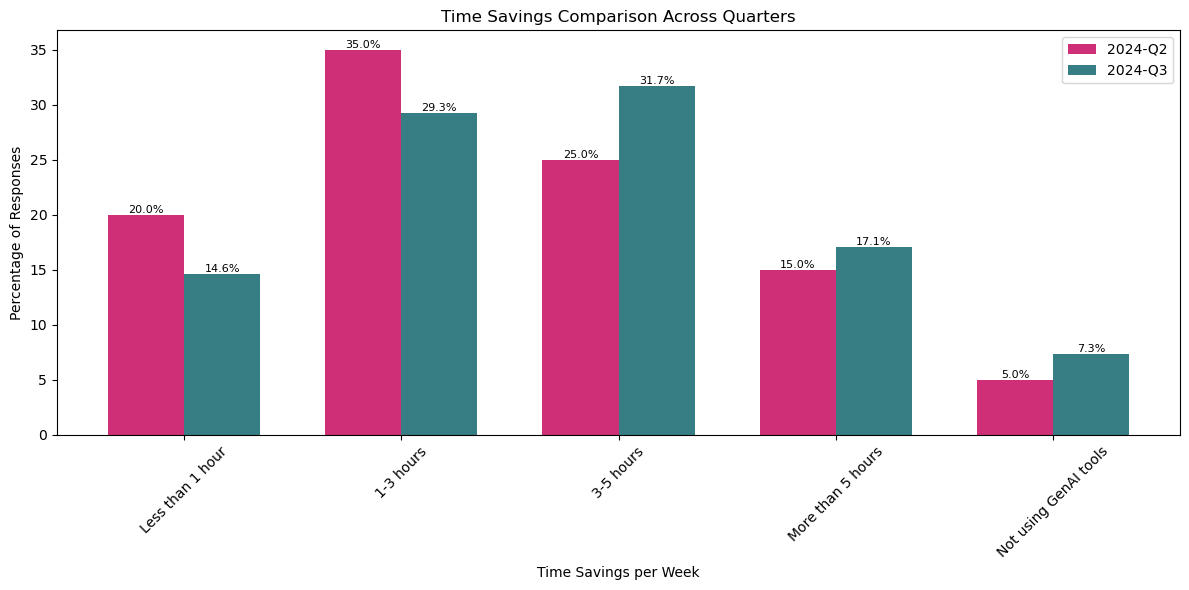

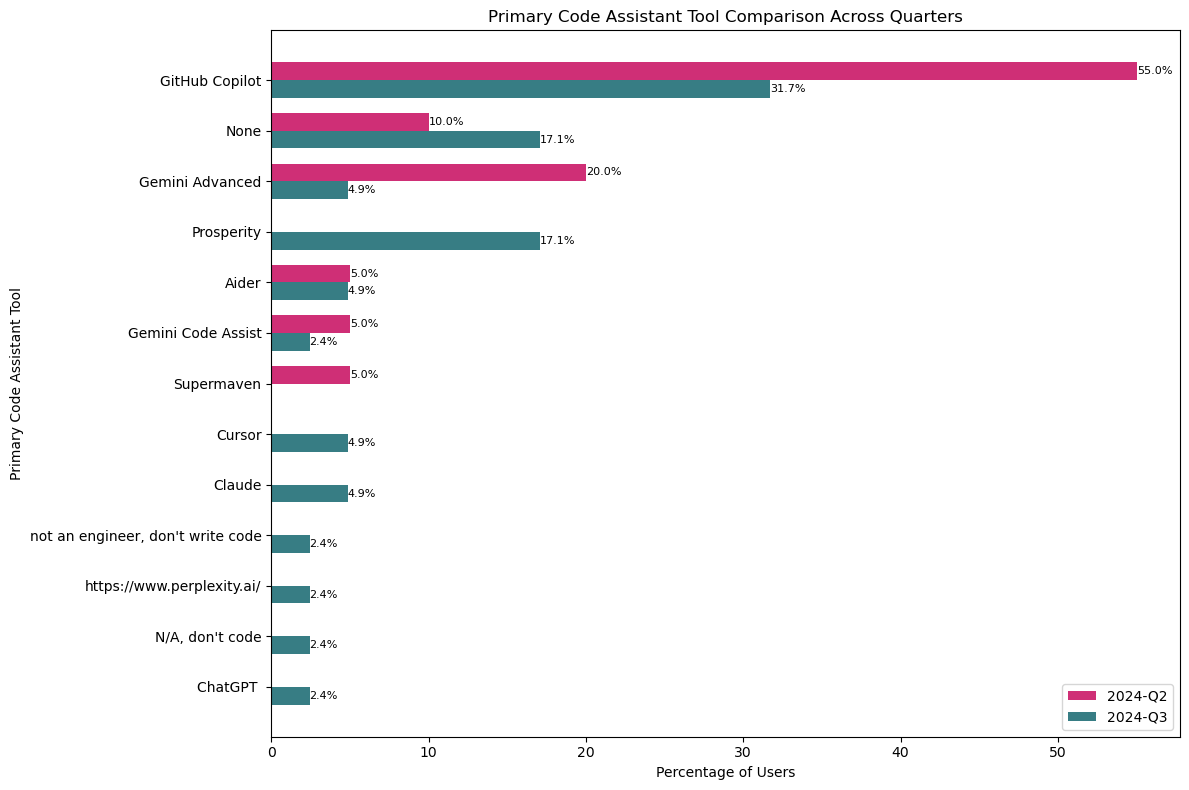

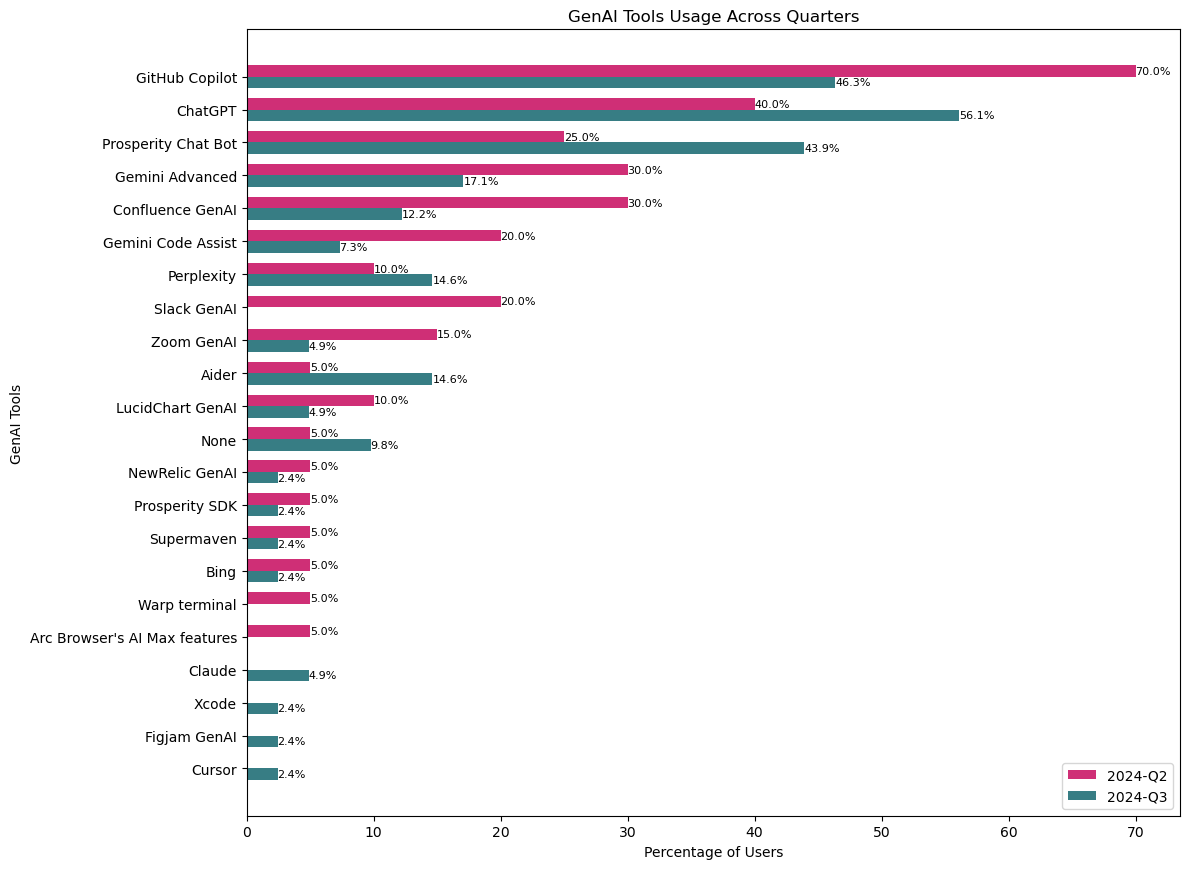

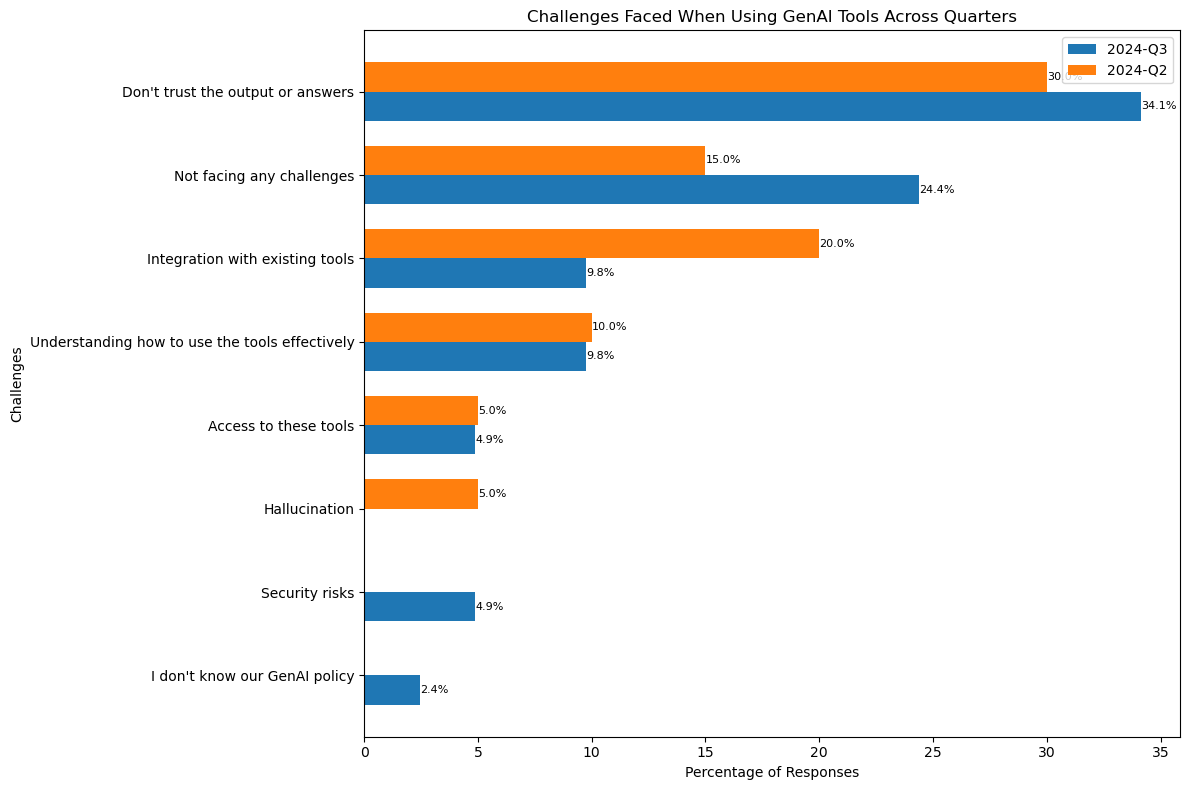

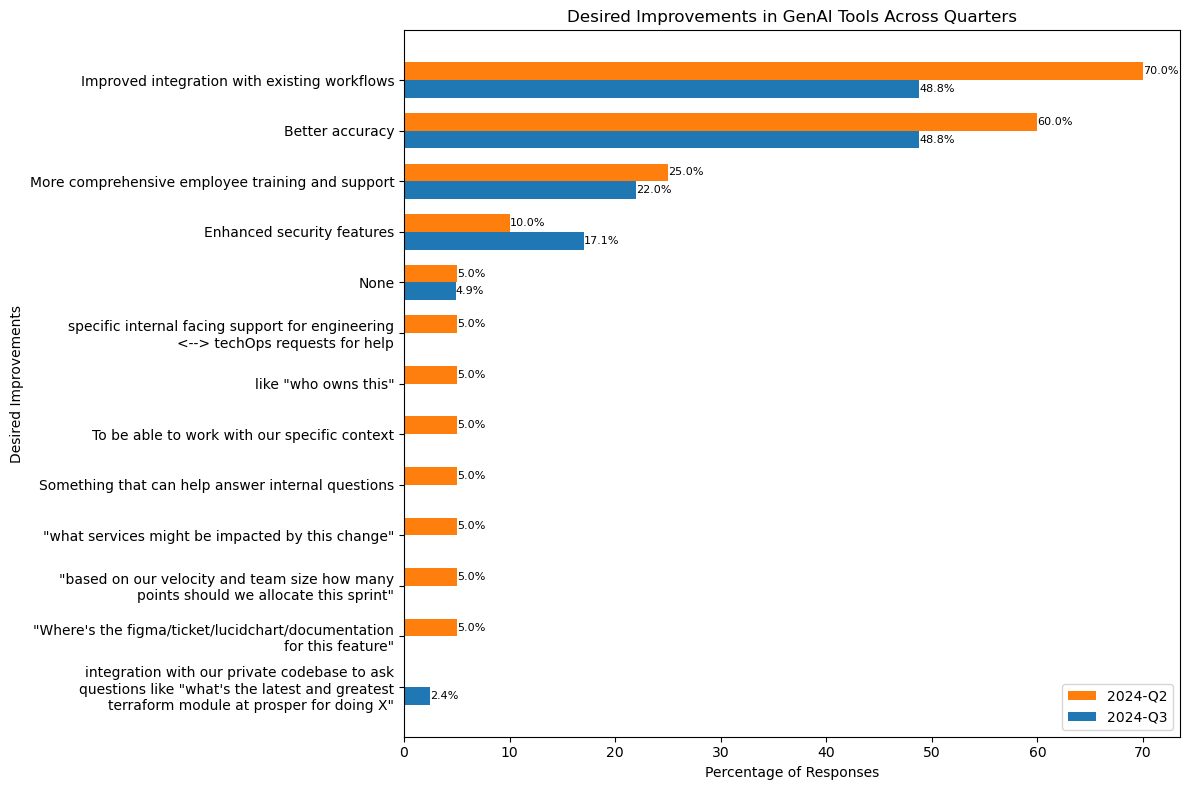

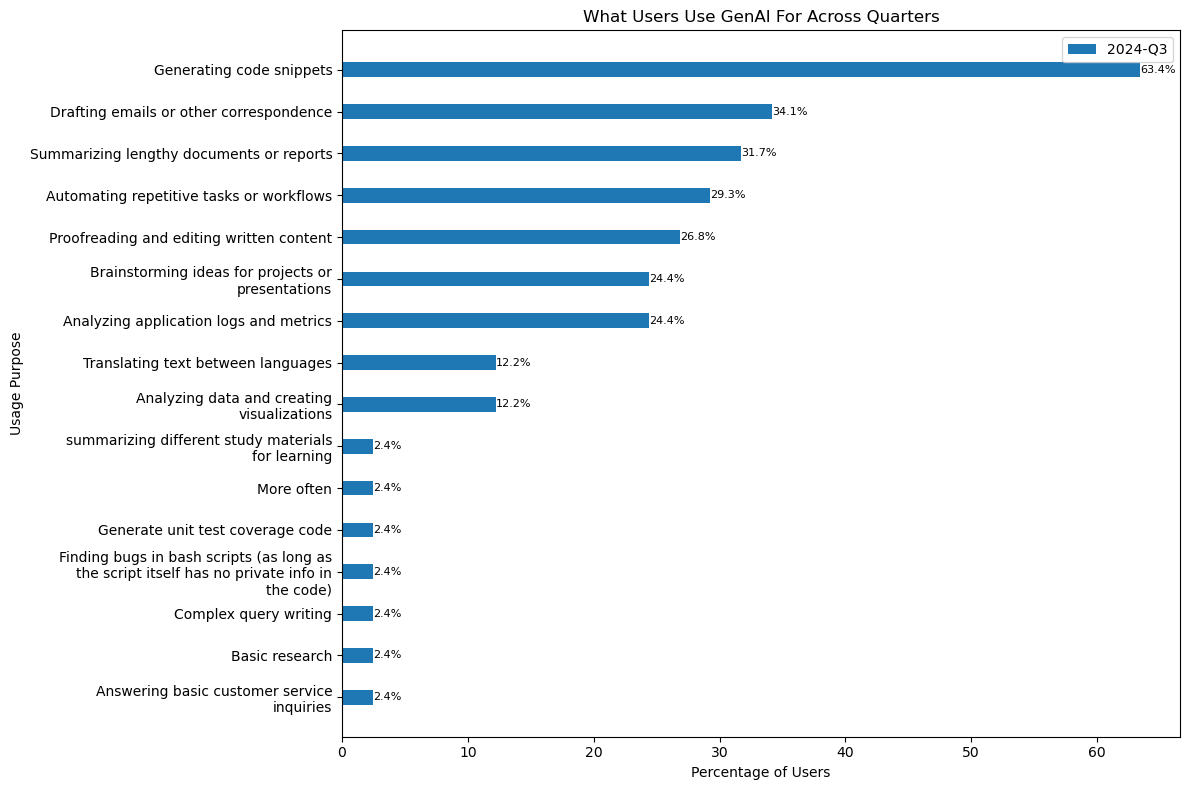

In [10]:
def create_time_savings_chart():
    plt.figure(figsize=(12, 6))
    
    # Define the desired order
    category_order = [
        'Less than 1 hour',
        '1-3 hours',
        '3-5 hours',
        'More than 5 hours',
        'Not using GenAI tools'
    ]
    
    # Process each file
    quarters_data = {}
    
    for quarter, df in dfs.items():
        time_savings = df['How much time are you saving per week using GenAI tools? (Select One)'].value_counts()
        quarters_data[quarter] = time_savings
    
    # Create comparison DataFrame with specified order
    comparison_df = pd.DataFrame({
        quarter: [data.get(cat, 0) for cat in category_order]
        for quarter, data in quarters_data.items()
    }, index=category_order)
    
    # Convert to percentages
    for quarter in comparison_df.columns:
        comparison_df[quarter] = (comparison_df[quarter] / len(dfs[quarter])) * 100
    
    # Plot
    x = np.arange(len(category_order))
    width = 0.35
    n_quarters = len(dfs)
    
    # Colors
    colors = ['#CF2F76', '#377D84']
    
    # Convert items to list
    quarters_items = list(comparison_df.items())
    
    for i, (quarter, data) in enumerate(quarters_items):
        offset = width * (i - (n_quarters-1)/2)
        bars = plt.bar(x + offset, data, width, label=quarter, color=colors[i])
        
        # Add percentage labels
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                plt.text(bar.get_x() + bar.get_width()/2, height,
                        f'{height:.1f}%',
                        ha='center', va='bottom', fontsize=8)
    
    plt.xlabel('Time Savings per Week')
    plt.ylabel('Percentage of Responses')
    plt.title('Time Savings Comparison Across Quarters')
    plt.xticks(x, category_order, rotation=45)
    plt.legend()
    plt.tight_layout()
    
    return plt

def create_primary_tool_chart():
    plt.figure(figsize=(12, 8))
    
    # Process each file
    all_tools = set()
    quarters_data = {}
    
    for quarter, df in dfs.items():
        # Convert NaN and empty strings to 'Not Specified'
        df['Primary Tool'] = df['What is your primary code assistant tool? (Select One)'].fillna('Not Specified')
        df['Primary Tool'] = df['Primary Tool'].replace('', 'Not Specified')
        tools = df['Primary Tool'].value_counts()
        
        # Store the data and collect unique tools
        quarters_data[quarter] = tools
        all_tools.update(tools.index)
    
    # Convert to list and sort, excluding 'Not Specified'
    all_tools = sorted([tool for tool in all_tools if tool != 'Not Specified'])
    # Add 'Not Specified' at the end if it exists
    if 'Not Specified' in all_tools:
        all_tools.append('Not Specified')
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        quarter: [data.get(tool, 0) for tool in all_tools]
        for quarter, data in quarters_data.items()
    }, index=all_tools)
    
    # Convert to percentages
    for quarter in comparison_df.columns:
        total_responses = len(dfs[quarter])
        comparison_df[quarter] = (comparison_df[quarter] / total_responses) * 100
    
    # Sort by total usage (excluding 'Not Specified')
    comparison_df['Total'] = comparison_df.sum(axis=1)
    
    # Separate 'Not Specified' row if it exists
    not_specified_row = None
    if 'Not Specified' in comparison_df.index:
        not_specified_row = comparison_df.loc[['Not Specified']]
        comparison_df = comparison_df.drop('Not Specified')
    
    # Sort the rest
    comparison_df = comparison_df.sort_values('Total', ascending=True)
    
    # Add back 'Not Specified' at the bottom if it existed
    if not_specified_row is not None:
        comparison_df = pd.concat([comparison_df, not_specified_row])
    
    comparison_df = comparison_df.drop('Total', axis=1)
    
     # Reverse the order of the columns to change bar order
    # comparison_df = comparison_df.iloc[::-1] 
    
    # Plot
    x = np.arange(len(comparison_df.index))
    width = 0.35
    
    # Colors
    colors = ['#CF2F76', '#377D84']
    colors.reverse()
    
    # Create bars for each quarter
    for i, quarter in enumerate(reversed(comparison_df.columns)):
        offset = width * (i - (len(comparison_df.columns)-1)/2)
        bars = plt.barh(x + offset, comparison_df[quarter], width, label=quarter, color=colors[i])
        
        # Add percentage labels
        for bar in bars:
            width_val = bar.get_width()
            if width_val > 0:
                plt.text(width_val, bar.get_y() + bar.get_height()/2,
                        f'{width_val:.1f}%',
                        ha='left', va='center', fontsize=8)
    
    plt.ylabel('Primary Code Assistant Tool')
    plt.xlabel('Percentage of Users')
    plt.title('Primary Code Assistant Tool Comparison Across Quarters')
    plt.yticks(x, comparison_df.index)
    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[::-1]
    labels = labels[::-1]
    plt.legend(handles, labels)
    plt.tight_layout()
    
    return plt

def create_tools_usage_chart():
    plt.figure(figsize=(12, 8))
    
    # Process each file
    all_tools = set()
    quarters_data = {}
    
    for quarter, df in dfs.items():
        # Handle the multiple selection column
        tools = df['I am using the following GenAI Tools (Select all that apply)'].fillna('Not Specified')
        tools = tools.replace('', 'Not Specified')
        
        # Split multiple selections and create a series of counts
        tools_list = tools.str.split(',').explode()
        tools_list = tools_list.str.strip()  # Remove leading/trailing whitespace
        
        # Clean up long strings and wrap them
        tools_list = tools_list.apply(lambda x: '\n'.join(textwrap.wrap(x, width=30)) if isinstance(x, str) else x)
        
        tool_counts = tools_list.value_counts()
        
        quarters_data[quarter] = tool_counts
        all_tools.update(tool_counts.index)
    
    # Convert to list and sort, excluding 'Not Specified'
    all_tools = sorted([tool for tool in all_tools if tool != 'Not Specified'])
    # Add 'Not Specified' at the end if it exists
    if 'Not Specified' in all_tools:
        all_tools.append('Not Specified')
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        quarter: [data.get(tool, 0) for tool in all_tools]
        for quarter, data in quarters_data.items()
    }, index=all_tools)
    
    # Convert to percentages
    for quarter in comparison_df.columns:
        total_responses = len(dfs[quarter])
        comparison_df[quarter] = (comparison_df[quarter] / total_responses) * 100
    
    # Sort by total usage (excluding 'Not Specified')
    comparison_df['Total'] = comparison_df.sum(axis=1)
    
    # Separate 'Not Specified' row if it exists
    not_specified_row = None
    if 'Not Specified' in comparison_df.index:
        not_specified_row = comparison_df.loc[['Not Specified']]
        comparison_df = comparison_df.drop('Not Specified')
    
    # Sort the rest
    comparison_df = comparison_df.sort_values('Total', ascending=True)
    
    # Add back 'Not Specified' at the bottom if it existed
    if not_specified_row is not None:
        comparison_df = pd.concat([comparison_df, not_specified_row])
    
    comparison_df = comparison_df.drop('Total', axis=1)
    
    # Plot
    x = np.arange(len(comparison_df.index))
    width = 0.35
    
     # Colors
    colors = ['#CF2F76', '#377D84']
    colors.reverse()
    
    # Create bars for each quarter
    for i, quarter in enumerate(reversed(comparison_df.columns)):
        offset = width * (i - (len(comparison_df.columns)-1)/2)
        bars = plt.barh(x + offset, comparison_df[quarter], width, label=quarter, color=colors[i])
        
        # Add percentage labels
        for bar in bars:
            width_val = bar.get_width()
            if width_val > 0:
                plt.text(width_val, bar.get_y() + bar.get_height()/2,
                        f'{width_val:.1f}%',
                        ha='left', va='center', fontsize=8)
    
    plt.ylabel('GenAI Tools')
    plt.xlabel('Percentage of Users')
    plt.title('GenAI Tools Usage Across Quarters')
    
    # Adjust figure size based on number of tools
    fig = plt.gcf()
    fig.set_size_inches(12, max(8, len(comparison_df) * 0.4))
    
    # Set yticks with wrapped labels
    plt.yticks(x, comparison_df.index)
    
    # Adjust layout to prevent label cutoff
    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[::-1]
    labels = labels[::-1]
    plt.legend(handles, labels)
    plt.tight_layout()
    
    return plt


# def create_challenges_chart():
#     plt.figure(figsize=(12, 8))
    
#     # Process each file
#     all_challenges = set()
#     quarters_data = {}
    
#     for quarter, df in dfs.items():
#         # Handle the column without splitting on commas
#         challenges = df['What challenges are you facing when using GenAI tools? (Select all that apply)'].fillna('Not Specified')
#         challenges = challenges.replace('', 'Not Specified')
        
#         # Clean up whitespace
#         challenges = challenges.str.strip()
        
#         # Clean up long strings and wrap them
#         challenges = challenges.apply(lambda x: '\n'.join(textwrap.wrap(x, width=50)) if isinstance(x, str) else x)
        
#         # Get value counts without exploding
#         challenge_counts = challenges.value_counts()
        
#         quarters_data[quarter] = challenge_counts
#         all_challenges.update(challenge_counts.index)
    
#     # Convert to list and sort, excluding 'Not Specified'
#     all_challenges = sorted([ch for ch in all_challenges if ch != 'Not Specified'])
#     # Add 'Not Specified' at the end if it exists
#     if 'Not Specified' in all_challenges:
#         all_challenges.append('Not Specified')
    
#     # Create comparison DataFrame
#     comparison_df = pd.DataFrame({
#         quarter: [data.get(challenge, 0) for challenge in all_challenges]
#         for quarter, data in quarters_data.items()
#     }, index=all_challenges)
    
#     # Convert to percentages
#     for quarter in comparison_df.columns:
#         total_responses = len(dfs[quarter])
#         comparison_df[quarter] = (comparison_df[quarter] / total_responses) * 100
    
#     # Sort by total usage (excluding 'Not Specified')
#     comparison_df['Total'] = comparison_df.sum(axis=1)
    
#     # Separate 'Not Specified' row if it exists
#     not_specified_row = None
#     if 'Not Specified' in comparison_df.index:
#         not_specified_row = comparison_df.loc[['Not Specified']]
#         comparison_df = comparison_df.drop('Not Specified')
    
#     # Sort the rest
#     comparison_df = comparison_df.sort_values('Total', ascending=True)
    
#     # Add back 'Not Specified' at the bottom if it existed
#     if not_specified_row is not None:
#         comparison_df = pd.concat([comparison_df, not_specified_row])
    
#     comparison_df = comparison_df.drop('Total', axis=1)
    
#     # Plot
#     x = np.arange(len(comparison_df.index))
#     width = 0.35
    
#     # Create bars for each quarter
#     for i, quarter in enumerate(reversed(comparison_df.columns)):
#         offset = width * (i - (len(comparison_df.columns)-1)/2)
#         bars = plt.barh(x + offset, comparison_df[quarter], width, label=quarter)
        
#         # Add percentage labels
#         for bar in bars:
#             width_val = bar.get_width()
#             if width_val > 0:
#                 plt.text(width_val, bar.get_y() + bar.get_height()/2,
#                         f'{width_val:.1f}%',
#                         ha='left', va='center', fontsize=8)
    
#     plt.ylabel('Challenges')
#     plt.xlabel('Percentage of Responses')
#     plt.title('Challenges Faced When Using GenAI Tools Across Quarters')
    
#     # Adjust figure size based on number of challenges
#     fig = plt.gcf()
#     fig.set_size_inches(12, max(8, len(comparison_df) * 0.4))
    
#     # Set yticks with wrapped labels
#     plt.yticks(x, comparison_df.index)
    
#     # Adjust layout to prevent label cutoff
#     plt.legend()
#     handles, labels = plt.gca().get_legend_handles_labels()
#     handles = handles[::-1]
#     labels = labels[::-1]
#     plt.legend(handles, labels)
#     plt.tight_layout()
    
#     return plt
def create_challenges_chart():
    plt.figure(figsize=(12, 8))
    
    # Process each file
    all_challenges = set()
    quarters_data = {}
    
    # Define common challenges to consolidate responses
    challenge_mapping = {
        "Don't trust the output or answers": ["Don't trust", "trust the output", "trust answers"],
        "Integration with existing tools": ["Integration with existing", "integrate"],
        "Understanding how to use the tools effectively": ["Understanding how to use", "how to use the tools"],
        "Security risks": ["Security risk"],
        "Access to these tools": ["Access to these tools"],
        "Creates more work": ["Creates more work"],
        "I don't know our GenAI policy": ["don't know our GenAI policy", "GenAI policy"],
        "Lack of training": ["Lack of training", "training"],
        "Not facing any challenges": ["Not facing any challenges"],
        "Hallucination": ["Hallucination"]
    }
    
    for quarter, df in dfs.items():
        # Handle the column without splitting on commas
        challenges = df['What challenges are you facing when using GenAI tools? (Select all that apply)'].fillna('Not Specified')
        challenges = challenges.replace('', 'Not Specified')
        
        # Clean up whitespace
        challenges = challenges.str.strip()
        
        # Consolidate similar responses
        def map_challenge(x):
            if pd.isna(x) or x == 'Not Specified':
                return x
            for main_category, keywords in challenge_mapping.items():
                if any(keyword.lower() in x.lower() for keyword in keywords):
                    return main_category
            return x
        
        challenges = challenges.apply(map_challenge)
        
        # Get value counts
        challenge_counts = challenges.value_counts()
        
        quarters_data[quarter] = challenge_counts
        all_challenges.update(challenge_counts.index)
    
    # Convert to list and sort, excluding 'Not Specified'
    all_challenges = sorted([ch for ch in all_challenges if ch != 'Not Specified' 
                           and ch in challenge_mapping.keys()])
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        quarter: [data.get(challenge, 0) for challenge in all_challenges]
        for quarter, data in quarters_data.items()
    }, index=all_challenges)
    
    # Convert to percentages
    for quarter in comparison_df.columns:
        total_responses = len(dfs[quarter])
        comparison_df[quarter] = (comparison_df[quarter] / total_responses) * 100
    
    # Sort by total usage
    comparison_df['Total'] = comparison_df.sum(axis=1)
    comparison_df = comparison_df.sort_values('Total', ascending=True)
    comparison_df = comparison_df.drop('Total', axis=1)
    
    # Plot
    x = np.arange(len(comparison_df.index))
    width = 0.35
    
    # Create bars for each quarter
    for i, quarter in enumerate(list(comparison_df.columns)[::-1]):
        offset = width * (i - (len(comparison_df.columns)-1)/2)
        bars = plt.barh(x + offset, comparison_df[quarter], width, label=quarter)
        
        # Add percentage labels
        for bar in bars:
            width_val = bar.get_width()
            if width_val > 0:
                plt.text(width_val, bar.get_y() + bar.get_height()/2,
                        f'{width_val:.1f}%',
                        ha='left', va='center', fontsize=8)
    
    plt.ylabel('Challenges')
    plt.xlabel('Percentage of Responses')
    plt.title('Challenges Faced When Using GenAI Tools Across Quarters')
    
    # Adjust figure size
    fig = plt.gcf()
    fig.set_size_inches(12, max(8, len(comparison_df) * 0.4))
    
    plt.yticks(x, comparison_df.index)
    plt.legend()
    plt.tight_layout()
    
    return plt

def create_improvements_chart():
    plt.figure(figsize=(12, 8))
    
    # Process each file
    all_improvements = set()
    quarters_data = {}
    
    for quarter, df in dfs.items():
        # Handle the multiple selection column
        improvements = df['What improvements or features would you like to see in GenAI tools? (Select all that apply)'].fillna('Not Specified')
        improvements = improvements.replace('', 'Not Specified')
        
        # Split multiple selections and create a series of counts
        improvement_list = improvements.str.split(',').explode()
        improvement_list = improvement_list.str.strip()  # Remove leading/trailing whitespace
        
        # Clean up long strings and wrap them
        improvement_list = improvement_list.apply(lambda x: '\n'.join(textwrap.wrap(x, width=50)) if isinstance(x, str) else x)
        
        improvement_counts = improvement_list.value_counts()
        
        quarters_data[quarter] = improvement_counts
        all_improvements.update(improvement_counts.index)
    
    # Convert to list and sort, excluding 'Not Specified'
    all_improvements = sorted([imp for imp in all_improvements if imp != 'Not Specified'])
    # Add 'Not Specified' at the end if it exists
    if 'Not Specified' in all_improvements:
        all_improvements.append('Not Specified')
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        quarter: [data.get(improvement, 0) for improvement in all_improvements]
        for quarter, data in quarters_data.items()
    }, index=all_improvements)
    
    # Convert to percentages
    for quarter in comparison_df.columns:
        total_responses = len(dfs[quarter])
        comparison_df[quarter] = (comparison_df[quarter] / total_responses) * 100
    
    # Sort by total usage (excluding 'Not Specified')
    comparison_df['Total'] = comparison_df.sum(axis=1)
    
    # Separate 'Not Specified' row if it exists
    not_specified_row = None
    if 'Not Specified' in comparison_df.index:
        not_specified_row = comparison_df.loc[['Not Specified']]
        comparison_df = comparison_df.drop('Not Specified')
    
    # Sort the rest
    comparison_df = comparison_df.sort_values('Total', ascending=True)
    
    # Add back 'Not Specified' at the bottom if it existed
    if not_specified_row is not None:
        comparison_df = pd.concat([comparison_df, not_specified_row])
    
    comparison_df = comparison_df.drop('Total', axis=1)
    
    # Plot
    x = np.arange(len(comparison_df.index))
    width = 0.35
    
    # Create bars for each quarter
    for i, quarter in enumerate(reversed(comparison_df.columns)):
        offset = width * (i - (len(comparison_df.columns)-1)/2)
        bars = plt.barh(x + offset, comparison_df[quarter], width, label=quarter)
        
        # Add percentage labels
        for bar in bars:
            width_val = bar.get_width()
            if width_val > 0:
                plt.text(width_val, bar.get_y() + bar.get_height()/2,
                        f'{width_val:.1f}%',
                        ha='left', va='center', fontsize=8)
    
    plt.ylabel('Desired Improvements')
    plt.xlabel('Percentage of Responses')
    plt.title('Desired Improvements in GenAI Tools Across Quarters')
    
    # Adjust figure size based on number of improvements
    fig = plt.gcf()
    fig.set_size_inches(12, max(8, len(comparison_df) * 0.4))
    
    # Set yticks with wrapped labels
    plt.yticks(x, comparison_df.index)
    
    # Adjust layout to prevent label cutoff
    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[::-1]
    labels = labels[::-1]
    plt.legend(handles, labels)
    plt.tight_layout()
    
    return plt

def create_genai_usage_purpose_chart():
    plt.figure(figsize=(12, 8))
    
    # Process each file
    all_purposes = set()
    quarters_data = {}
    
    for quarter, df in dfs.items():
        # Check if the column exists in this quarter's data
        if 'What do you use GenAI for?' not in df.columns:
            continue
            
        # Handle the multiple selection column
        purposes = df['What do you use GenAI for?'].fillna('Not Specified')
        purposes = purposes.replace('', 'Not Specified')
        
        # Split multiple selections and create a series of counts
        purposes_list = purposes.str.split(',').explode()
        purposes_list = purposes_list.str.strip()  # Remove leading/trailing whitespace
        
        # Clean up long strings and wrap them
        purposes_list = purposes_list.apply(lambda x: '\n'.join(textwrap.wrap(x, width=40)) if isinstance(x, str) else x)
        
        purpose_counts = purposes_list.value_counts()
        
        quarters_data[quarter] = purpose_counts
        all_purposes.update(purpose_counts.index)
    
    # If no data was found, return early
    if not quarters_data:
        plt.close()
        return plt
    
    # Convert to list and sort, excluding 'Not Specified'
    all_purposes = sorted([purpose for purpose in all_purposes if purpose != 'Not Specified'])
    # Add 'Not Specified' at the end if it exists
    if 'Not Specified' in all_purposes:
        all_purposes.append('Not Specified')
    
    # Create comparison DataFrame
    comparison_df = pd.DataFrame({
        quarter: [data.get(purpose, 0) for purpose in all_purposes]
        for quarter, data in quarters_data.items()
    }, index=all_purposes)
    
    # Convert to percentages
    for quarter in comparison_df.columns:
        total_responses = len(dfs[quarter])
        comparison_df[quarter] = (comparison_df[quarter] / total_responses) * 100
    
    # Sort by total usage (excluding 'Not Specified')
    comparison_df['Total'] = comparison_df.sum(axis=1)
    
    # Separate 'Not Specified' row if it exists
    not_specified_row = None
    if 'Not Specified' in comparison_df.index:
        not_specified_row = comparison_df.loc[['Not Specified']]
        comparison_df = comparison_df.drop('Not Specified')
    
    # Sort the rest
    comparison_df = comparison_df.sort_values('Total', ascending=True)
    
    # Add back 'Not Specified' at the bottom if it existed
    if not_specified_row is not None:
        comparison_df = pd.concat([comparison_df, not_specified_row])
    
    comparison_df = comparison_df.drop('Total', axis=1)
    
    # Plot
    x = np.arange(len(comparison_df.index))
    width = 0.35
    
    # Create bars for each quarter
    for i, quarter in enumerate(reversed(comparison_df.columns)):
        offset = width * (i - (len(comparison_df.columns)-1)/2)
        bars = plt.barh(x + offset, comparison_df[quarter], width, label=quarter)
        
        # Add percentage labels
        for bar in bars:
            width_val = bar.get_width()
            if width_val > 0:
                plt.text(width_val, bar.get_y() + bar.get_height()/2,
                        f'{width_val:.1f}%',
                        ha='left', va='center', fontsize=8)
    
    plt.ylabel('Usage Purpose')
    plt.xlabel('Percentage of Users')
    plt.title('What Users Use GenAI For Across Quarters')
    
    # Adjust figure size based on number of purposes
    fig = plt.gcf()
    fig.set_size_inches(12, max(8, len(comparison_df) * 0.4))
    
    # Set yticks with wrapped labels
    plt.yticks(x, comparison_df.index)
    
    # Adjust layout to prevent label cutoff
    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[::-1]
    labels = labels[::-1]
    plt.legend(handles, labels)
    plt.tight_layout()
    
    return plt


# Create and display all charts
charts = {
    'Time Savings': create_time_savings_chart(),
    'Primary Tools': create_primary_tool_chart(),
    'Tools Usage': create_tools_usage_chart(),
    'Challenges': create_challenges_chart(),
    'Improvements': create_improvements_chart(),
    'GenAI Usage Purpose': create_genai_usage_purpose_chart()
}

# Display all charts
for name, chart in charts.items():
    chart.show()